## What is clustering?

Human beings like to organize things into groups. It's universally acknowledged truth. In data analysis, we may divide things by city of origin, or gender, or create age groups, among others. These are examples of manual clustering, where we define the bounds (the criteria that separate groups) ourselves.

When it comes to dealing with more than one variable at a time, however, it is easier to let an algorithm organize data points with similar characteristics into groups. Some algorithms use _hard clustering_, where each data point is assigned to only one cluster; others use _soft clustering_, where each data point is assigned a degree of membership for every cluster. We will mostly review hard clustering options here.  Either way, an algorithmic cluster is a set of data points that have been determined to be more similar to one another than to other data points. The way that similarity is determined is what differentiates the various clustering methods.

Clustering is useful as a method of generating features for a model, as well as a way of learning more about associations between data points. However, there are also some caveats: First, it is important to normalize data before clustering them, so that all variables have equal potential impact on the clustering algorithm. And second, just because an algorithm can find a certain number of clusters doesn't mean those clusters are meaningful. If the number of clusters we request is too large, or the algorithm grabs too many clusters, groups will start to split on trivial differences, leading to overfitting. If there are too few clusters, we won't get much information from them, and real differences between data points can be obscured.

We can also cluster hierarchically, where lower-level clusters are formed and then grouped into higher-level clusters. This can be useful if we are interested in subdivisions within a larger cluster. For example, imagine we have four clusters: young men, young women, older men, and older women.  If all we have are those four clusters, we don't really know whether the young men are more similar to the young women, or to the older men.  To find this out, we could do hierarchical clustering, where we first have the four lower-level clusters, but then we also add two high-level clusters (men vs women, or young vs old) that would show us which lower-level clusters have more in common.

Now let's get to clustering!


## Clustering with K-Means



In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline
sns.set()

$k$-means is a mathematically straightforward but computationally intensive hard-clustering method for grouping data into clusters of similar data points with similar variances.  It uses a cost function called the *inertia*, and the algorithm tries to choose means (called *centroids*) that minimize the inertia.  If you recall the lesson on linear regression, the formula for inertia may be familiar:

$$\sum(\bar{x}_c - x_i)^2$$

In words, the inertia is the sum of the squared differences between the centroid of a cluster (the mean $\bar{x}_c$) and the data points in the cluster ($x_i$).  The goal is to define cluster means so that the distance between a cluster mean and all the data points within the cluster is as small as possible.

So the *means* in $k$-means refers to the centroids.  The $k$ is the number of centroids (and thus, the number of clusters) the algorithm works with, which is provided by the user.  It's a pretty literal name.

How do you pick $k$?  Basically through trial and error.   Pick a $k$, look at the solution, see if it makes sense, then try other $k$'s.  Clusters representing "real" divisions in the data will be stable across training set and test set.

## How the algorithm works

$k$-means is an iterative algorithm that eventually converges on a solution.  It begins by choosing $k$ centroids at random, then repeats the following two steps until convergence:

1. Assign each data point to the nearest centroid
2. Create new centroids by taking the mean of all the data points assigned to each centroid

The algorithm stops when the difference between the old and new centroids is lower than a given threshold.

Like other iterative algorithms with a random start, bad starting centroid values can cause $k$-means to arrive at a lousy solution.  As a result, it is recommended to try the algorithm a few times with different starting centroids.  The sklearn implementation has a nifty `kmeans++` option for initializing centroids that are distant from each other, which is less likely to end in a flawed solution.


## Assumptions made by $k$-means models

$k$-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward.  It also assumes all clusters have similar variances.  See these [pictures of clusters](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) that do and do not fit the $k$-means isotropic and variance assumptions.  

## Speed

High-dimensional data tends to make $k$-means run more slowly because it is more computationally demanding to measure the distance between each data point and the mean in a higher-dimensional space. A common practice is to run a PCA on the data first to reduce dimensionality, and then search for clusters in the reduced data.

If you don't want to reduce dimensions but you do have limited computational power or time, a different option is MiniBatchKMeans in sklearn, which randomly samples subsets of the training data in each iteration.  The loop steps are similar to those in the original:

 1. Assign the samples to their nearest centroids.
 2. Update the centroids based on the streaming average of all of the samples that have been assigned to the centroid so far.

The solution you get will be a little worse than regular $k$-means but drastically faster.

## Applying the model

Let's try $k$-means on some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.  Our goal will be to create a $k$-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


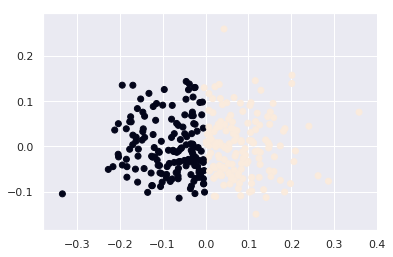

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [4]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Looks like this model isn't doing very well. We're correctly classifying 182 cases, but mis-classifying 120 of the cases!

Now let's try MiniBatch:

In [5]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0        0  140
1      149   14


# This marks a significant change. How substantial is the computational performance improvement? Try re-running the $k$-means and mini batch $k$-means models and timing their execution. Check out the [%timeit magic](https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit) for helpful timing tools.

## I wanted this to actually be useful, so I have been trying to capture the times for each KMeans and mini-KMeans run in the loop below, so I can capture the times while looping, and plot them against each other. This has proven to be difficult and I'm not wasting any more time on it. 

## The problem is that I don't seem to be able to assign the output of fit_predict to a variable--my code kept plotting the values for y_pred that I set while testing a single run outside of the loop, though the rest of the loop was apparently getting the correct (incrementing) value for num_clusters 

### I did see that the mini batch run was consistently faster--sometimes not much faster, but always faster.

## Drill: More clusters?

Your task is to take the $k$-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

In [6]:
timeit_list = []

In [7]:
timeit_entry = %timeit -c -o
y_pred = KMeans(n_clusters=2, random_state=99).fit_predict(X_pca)

In [8]:
timeit_list.append(timeit_entry.best)

AttributeError: 'NoneType' object has no attribute 'best'

In [27]:
#km_times = []
#mini_times = []
def try_x_clusters(num_clusters):
    fig = plt.figure(figsize=(10,10))
    #y_pred = 0
    print("\n*** Trying {} clusters:".format(num_clusters))
    
# Calculate predicted values.
    #km_time = %timeit -c -o 
    ax = y_pred = KMeans(n_clusters=num_clusters, random_state=99).fit_predict(X_pca)
    #km_times.append(km_time.best)

# Plot the solution.
    markers = {0: "X",1: "s"}
    sns.scatterplot(X_pca[:, 0], X_pca[:, 1],
                    hue=y_pred,
                    style=y,
                    palette='Set1',
                    markers=markers,
                    legend='full')
    plt.show()

# Check the solution against the data.
    print('Comparing k-means clusters against the data:')
    km_crosstab = pd.crosstab(y_pred, y)
    print(km_crosstab)
    
# Each batch will be made up of 200 data points.
    minibatchkmeans = MiniBatchKMeans(
        init='random',
        n_clusters=num_clusters,
        batch_size=200)
    minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
    #mini_time = %timeit -c 
    predict_mini = minibatchkmeans.predict(X_pca)
    #mini_times.append(mini_time.best)

# Check the MiniBatch model against our earlier one.
    print('Comparing mini batch k-means against the data:')
    print(pd.crosstab(predict_mini,y))

    return km_crosstab
#ax = sns.scatterplot(km_times,mini_times)
#ax.set(xlabel='KMeans time',ylabel='Mini-KMeans time')

In the scatterplots below, a small x is an observation of no heart disease, and a square is an observation of heart disease.

I sort of see in some of the plots where heart disease dominates the observations of some of the clusters, but I didn't see anything that really jumped out at me through 9 different plots (featuring 2-10 clusters). Really hoping I'm not just missing something...?


*** Trying 2 clusters:


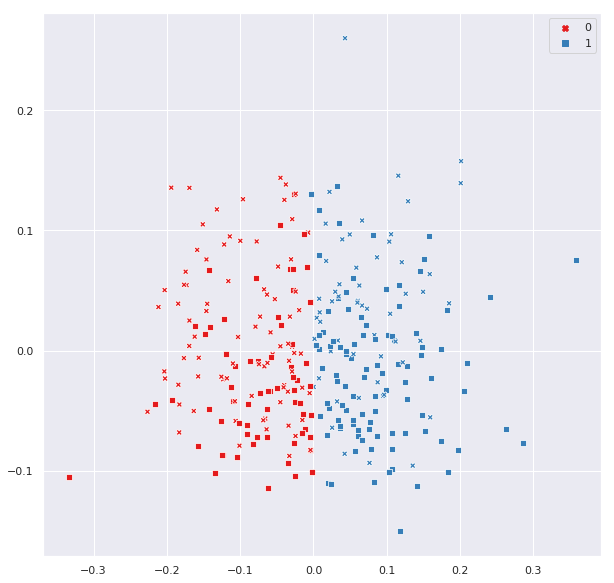

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99
Comparing mini batch k-means against the data:
col_0   0    1
row_0         
0      56  102
1      83   62

*** Trying 3 clusters:


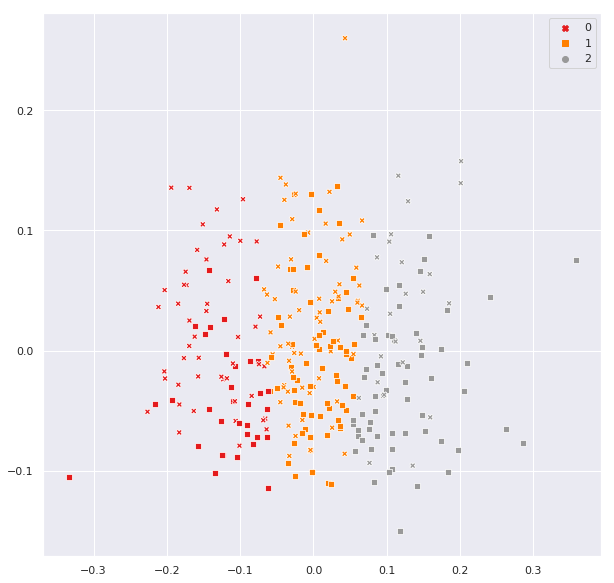

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      49  33
1      65  70
2      25  61
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      23  50
1      59  78
2      57  36

*** Trying 4 clusters:


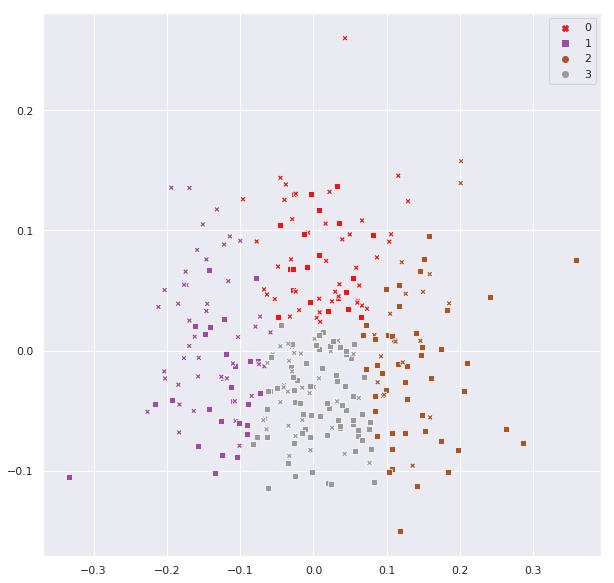

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      42  21
1      45  27
2      17  48
3      35  68
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      42  20
1      16  60
2      35  25
3      46  59

*** Trying 5 clusters:


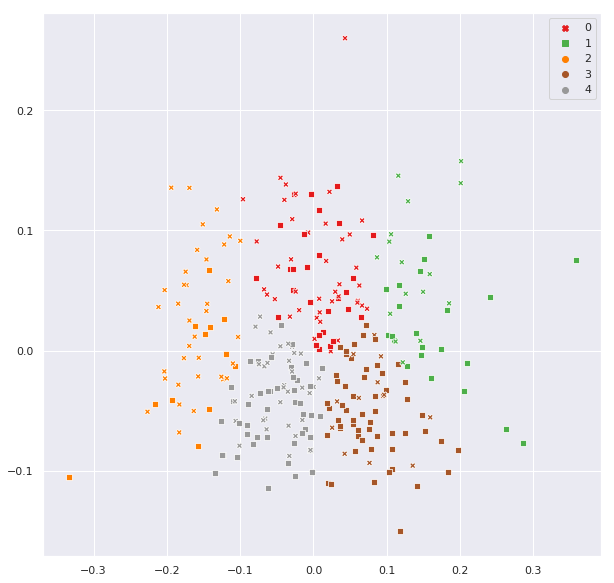

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      40  28
1      16  22
2      36  12
3      13  57
4      34  45
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      35  42
1      33  11
2      34  25
3      15  58
4      22  28

*** Trying 6 clusters:


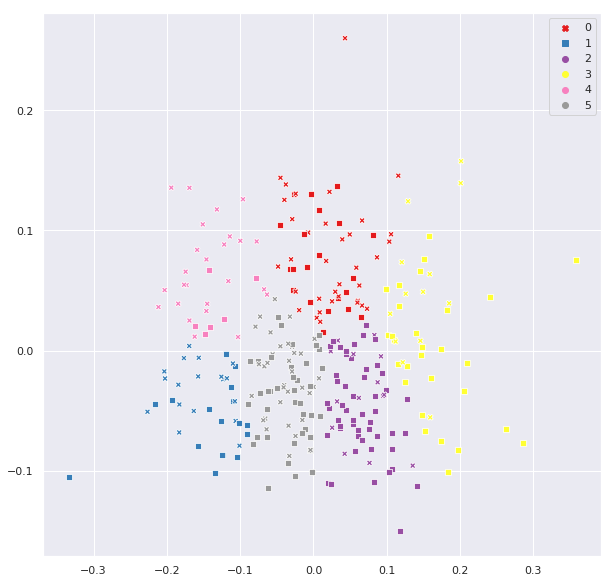

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      35  21
1      18  17
2      14  52
3      13  29
4      25   6
5      34  39
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      29   5
1      14  21
2      31  29
3      20  22
4      33  41
5      12  46

*** Trying 7 clusters:


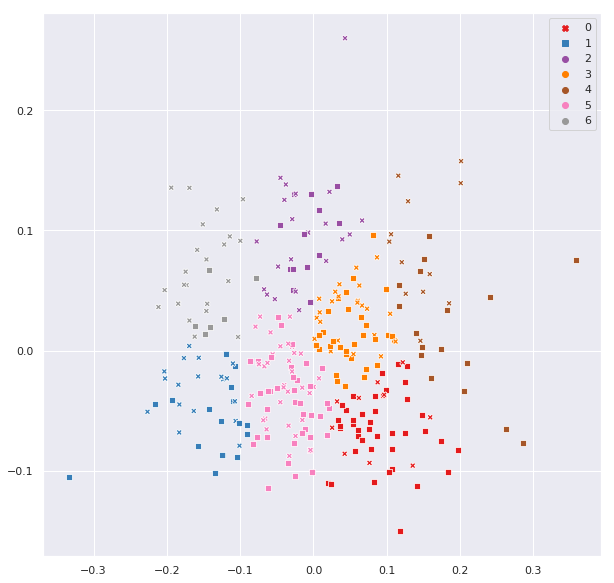

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      11  41
1      18  17
2      21  13
3      23  31
4      12  17
5      32  39
6      22   6
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      10  41
1      15  34
2      21  12
3      33  22
4      18  21
5      22   6
6      20  28

*** Trying 8 clusters:


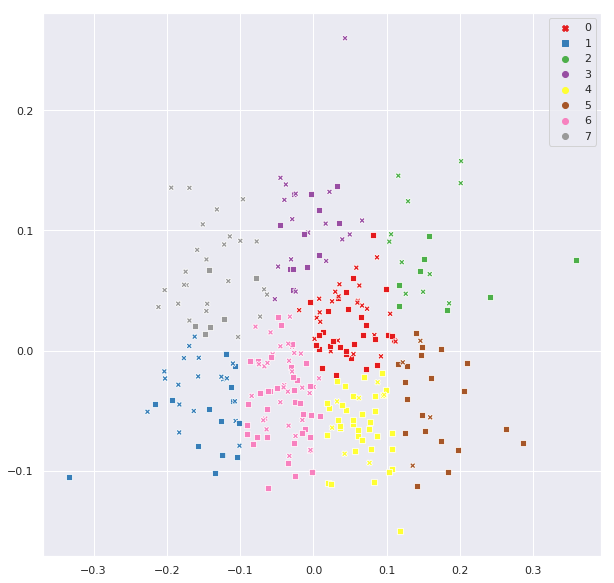

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      24  30
1      19  15
2      11   8
3      17  12
4       8  36
5       4  20
6      31  37
7      25   6
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      17  11
1      13  10
2      31  33
3      26   7
4       8  33
5       7  32
6      21  26
7      16  12

*** Trying 9 clusters:


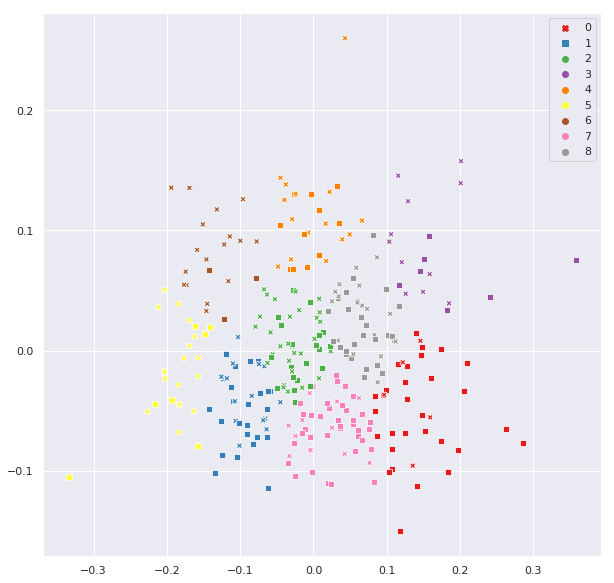

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0       5  30
1      15  24
2      29  20
3      11   7
4      15  11
5      16   7
6      17   3
7      13  37
8      18  25
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      22  14
1       5  22
2      14  11
3      19  18
4      15  26
5      18   9
6       9  38
7      20   5
8      17  21

*** Trying 10 clusters:


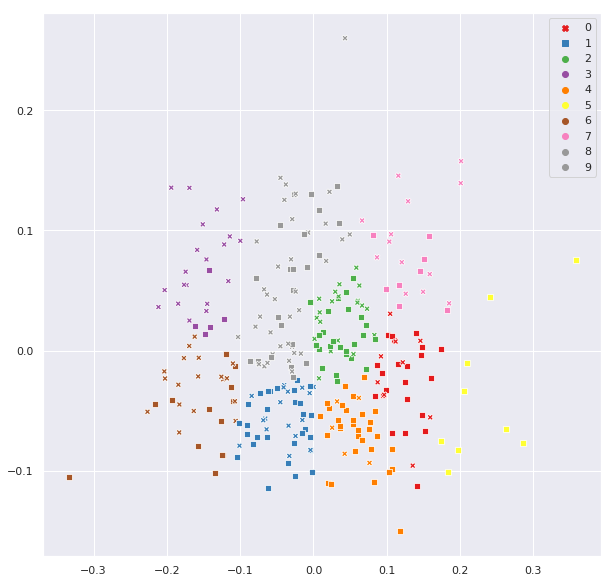

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0       9  22
1      17  29
2      20  25
3      20   5
4       6  31
5       0   9
6      18  13
7      13   8
8      21  11
9      15  11
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      11   4
1      15   7
2      18   6
3       8  15
4      16  16
5      20  19
6      13  28
7      15  22
8      16  13
9       7  34


In [10]:
for num_clusters in np.arange(2,11):
    try_x_clusters(num_clusters)

### So, I'm trying something they do in the clustering lectures in the Udemy course:

In [19]:
wcss = []
for i in range(1,20):
    kmeans = KMeans(i)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

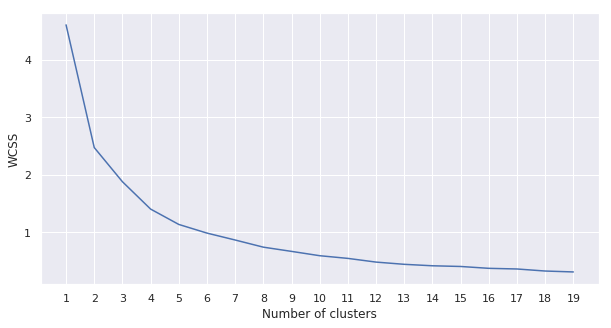

In [25]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20),wcss)
plt.xticks(np.arange(1,20,step=1))
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In the Udemy approach, they plot this "elbow"--WCSS = "within-cluster sums of squares"--and then see how their plot looks when is set k to numbers corresponding to bends in the elbow. 
The most obvious bends in the elbow here are at 2, 4, maybe 5, and maybe 8.

However, in the Udemy example, there were only two variables in the first place, and no additional classification. 

But let's look at 4 clusters again:


*** Trying 4 clusters:


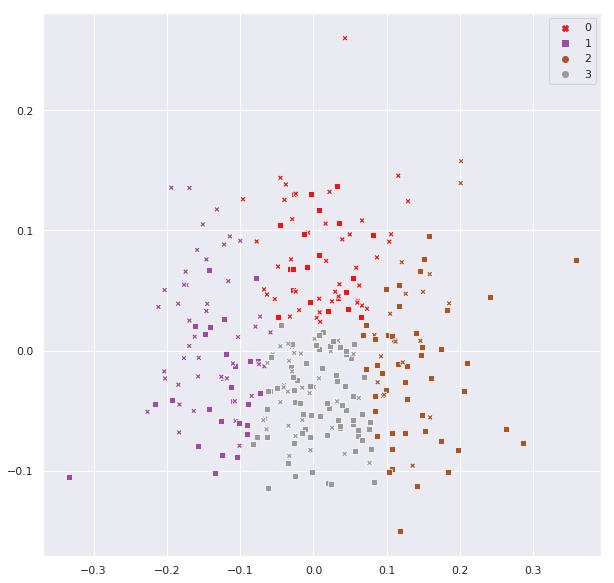

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      42  21
1      45  27
2      17  48
3      35  68
Comparing mini batch k-means against the data:
col_0   0   1
row_0        
0      27  55
1      37  33
2      43  62
3      32  14


In [39]:
k4_crosstab = try_x_clusters(4)

So none of these groups are really "clean" in the sense that they either contain all observations of heart disease, or no heart disease, but in each cluster one of those outcomes is definitely more likely than the other, particularly in cluster 2.

In [46]:
k4_crosstab['pct_heart_disease'] = k4_crosstab[1] / k4_crosstab.sum(axis=1)

In [47]:
k4_crosstab

col_0,0,1,pct_heart_disease
row_0,,,
0,42,21,0.332454
1,45,27,0.374350
2,17,48,0.735762
3,35,68,0.659169


Is this what I was supposed to notice last night?